# Appendix B: Level 1 Filters

#### After loading the data we apply four "Level 1" filters" detailed below:

* `“Identical Except Price” Filter:` The OptionMetrics data set contain duplicate observations, defined as two or more quotes with identical option type, strike, expiration date, and price. In each such case, we eliminate all but one of the quotes.

* `“Identical Except Price” Filter:` There are a few sets of quotes with identical terms (type, strike, and maturity) but different prices. When this occurs, we
keep the quote whose T-bill-based implied volatility is closest to that of its moneyness neighbors, and delete the others. 

* `“Bid = 0” Filter:` We remove quotes of zero for bids, thereby avoiding lowvalued options. Also, a zero bid may indicate censoring as negative bids cannot be recorded.

* `“Volume = 0” Filter:` We remove quotes of zero for volumes, thereby avoiding lowtraded options. 



In [1]:
import sys
sys.path.insert(1, './../src/')

import pandas as pd
import numpy as np
import config
from pathlib import Path 
import time 
import seaborn as sns
import matplotlib.pyplot as plt

import load_option_data_01 
import filter_option_data_01 as f1

OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
WRDS_USERNAME = config.WRDS_USERNAME

START_DATE_01 =config.START_DATE_01
END_DATE_01 = config.END_DATE_01

START_DATE_02 =config.START_DATE_02
END_DATE_02 = config.END_DATE_02

NOTE_START = START_DATE_01
NOTE_END = END_DATE_01

# Level 1 Filters: 

## Load Data

In [2]:
optm_l1_load = load_option_data_01.load_all_optm_data(data_dir=DATA_DIR,
											wrds_username=WRDS_USERNAME, 
											startDate=NOTE_START,
											endDate=NOTE_END)
optm_l1_load = f1.getSecPrice(optm_l1_load)
optm_l1_load = f1.calc_moneyness(optm_l1_load)

Reading from file: C:\Users\viren\Documents\_MSFM\FINM 32900 - Data Science Tools for Finance\finm-32900_final_project\data\pulled\data_1996-01_2012-01.parquet


Loading Data took 0.58 seconds


In [3]:
optm_l1_load.head()

,secid,date,open,close,cp_flag,exdate,impl_volatility,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,sec_price,mnyns
0,108105.0,1996-01-05,617.70,616.71,C,1996-03-16,NaN,0.0503,0.0,6527.0,92.875,93.875,525.0,100.0,616.71,0.851292
1,108105.0,1996-01-05,617.70,616.71,C,1996-03-16,NaN,0.0503,0.0,5101.0,68.750,69.750,550.0,100.0,616.71,0.891829
2,108105.0,1996-01-09,618.46,609.45,C,1996-02-17,NaN,0.0501,0.0,90.0,38.500,39.500,570.0,100.0,609.45,0.935270
3,108105.0,1996-01-09,618.46,609.45,C,1996-01-20,NaN,0.0501,0.0,1004.0,25.625,26.625,580.0,100.0,609.45,0.951678
4,108105.0,1996-01-17,608.44,606.37,C,1996-01-20,NaN,0.0499,80.0,3113.0,10.750,11.250,595.0,100.0,606.37,0.981249


## Plot Loaded Data

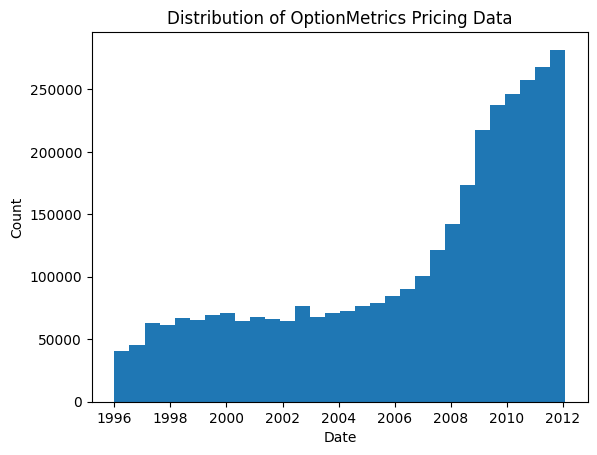

In [4]:
plt.hist(optm_l1_load['date'], bins=30)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of OptionMetrics Pricing Data')
plt.show()

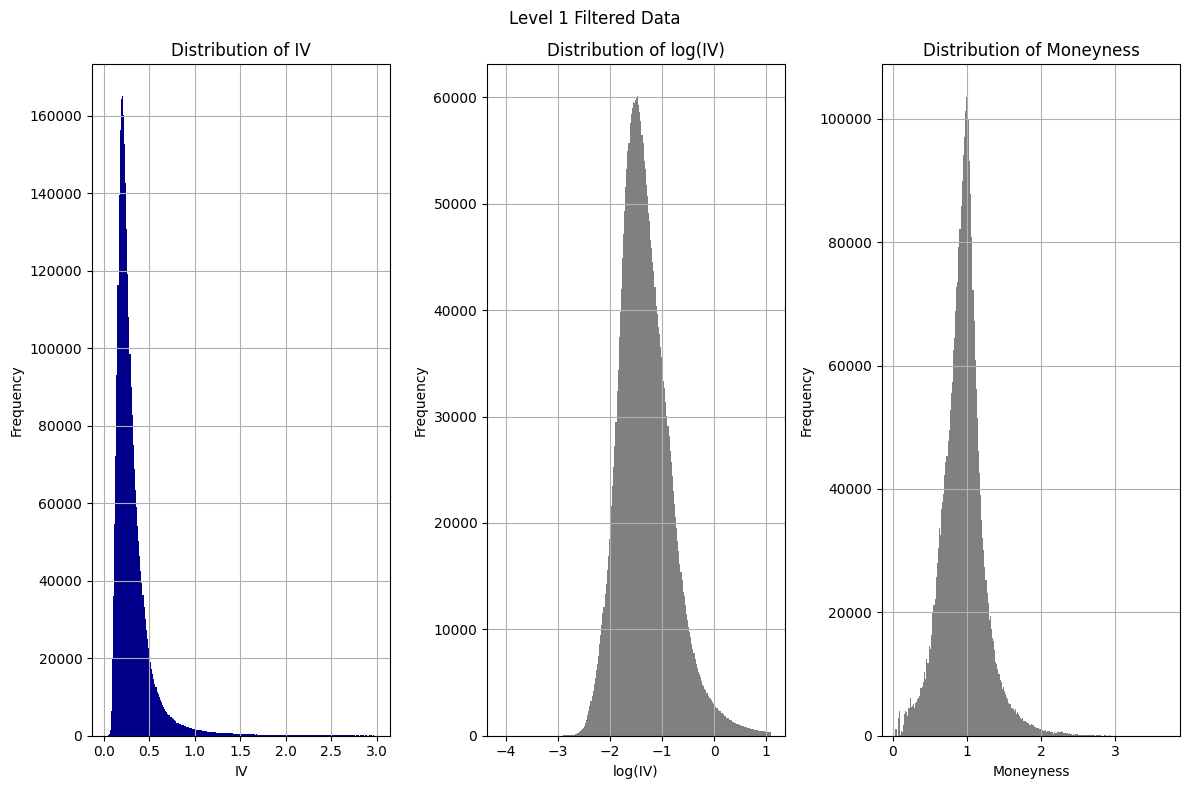

In [5]:

datplot = optm_l1_load
datplot['log_iv'] = np.log(datplot['impl_volatility'])
fig, ax = plt.subplots(1,3, figsize=(12,8))
axes = ax.flatten()

axes[0].hist(datplot['impl_volatility'], bins=250, color='darkblue')
axes[0].set_xlabel('IV')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of IV')
axes[0].grid()

axes[1].hist(datplot['log_iv'], bins=250, color='grey')
axes[1].set_xlabel('log(IV)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of log(IV)')
axes[1].grid()

j = 2
axes[j].hist(datplot['mnyns'], bins=250, color='grey')
axes[j].set_xlabel('Moneyness')
axes[j].set_ylabel('Frequency')
axes[j].set_title('Distribution of Moneyness')
axes[j].grid()



plt.suptitle('Level 1 Filtered Data')
plt.tight_layout()
plt.show()

## Filter Duplicates

The OptionMetrics data set contain duplicate observations,
defined as two or more quotes with identical option type, strike, expiration date, and price. In each such case, we eliminate all but one of the quotes. 

Replicating this step we found there was only one duplicate observation on March 27, 2007.

In [6]:
optm_l1_id = f1.delete_identical_filter(optm_l1_load)
optm_l1_load['best_mid']= (optm_l1_load['best_bid'] + optm_l1_load['best_offer'])/2

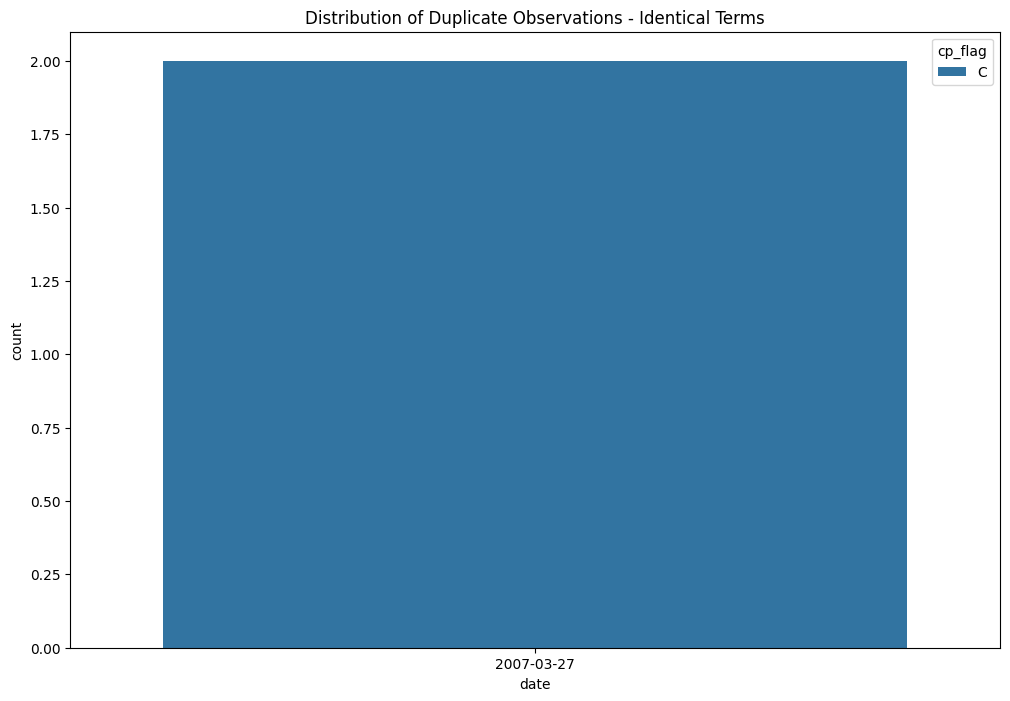

In [7]:
duplicate_counts = optm_l1_load.groupby(['date', 'cp_flag', 'strike_price', 'exdate', 'best_mid']).size().reset_index(name='count')
duplicate_counts = duplicate_counts.loc[duplicate_counts['count'] > 1]

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='date', y='count', hue='cp_flag', data=duplicate_counts)
ax.set_xlabel('date')
ax.set_ylabel('count')
ax.set_title('Distribution of Duplicate Observations - Identical Terms')
plt.show()

## Filter Identical in all but price

The OptionMetrics data set contain duplicate observations,
defined as two or more quotes with identical option type, strike, expiration
date, and price. In each such case, we eliminate all but one of the quotes.

In [8]:
optm_l1_idxp = f1.delete_identical_but_price_filter(optm_l1_id)

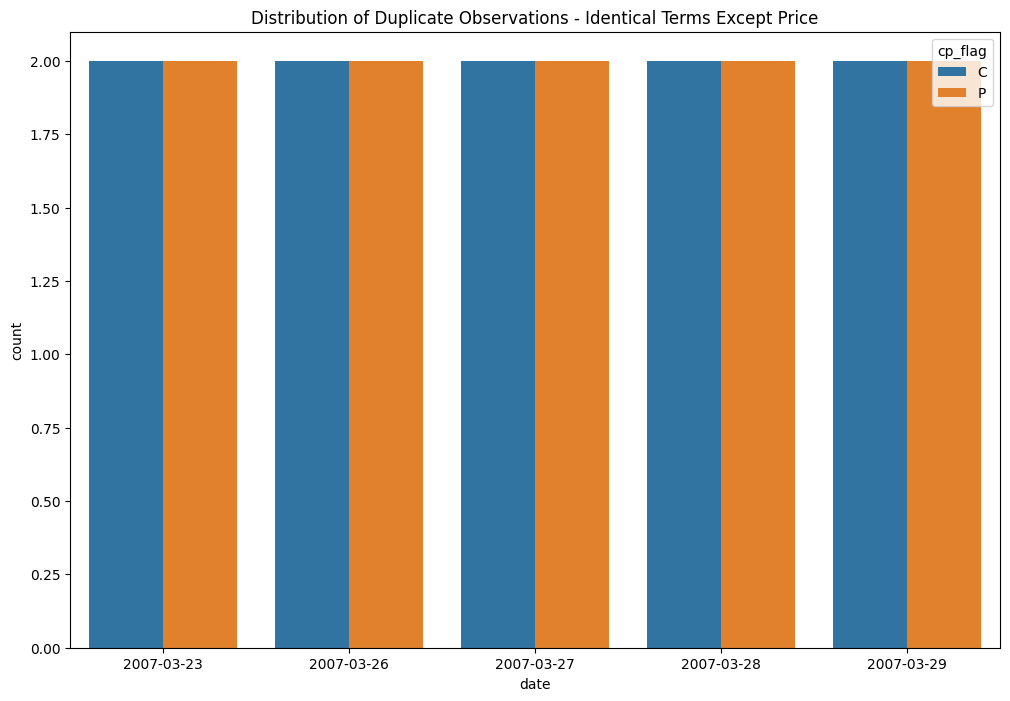

In [9]:
duplicate_counts = optm_l1_id.groupby(['date', 'cp_flag', 'strike_price', 'exdate']).size().reset_index(name='count')
duplicate_counts = duplicate_counts.loc[duplicate_counts['count'] > 1]

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='date', y='count', hue='cp_flag', data=duplicate_counts)
ax.set_xlabel('date')
ax.set_ylabel('count')
ax.set_title('Distribution of Duplicate Observations - Identical Terms Except Price')
plt.show()

## Filter Options with Bid = 0 

We remove quotes of zero for bids, thereby avoiding low-valued options. Also, a zero bid may indicate censoring as negative bids
cannot be recorded.

In [10]:
optm_l1_zbid = f1.delete_zero_bid_filter(optm_l1_id)

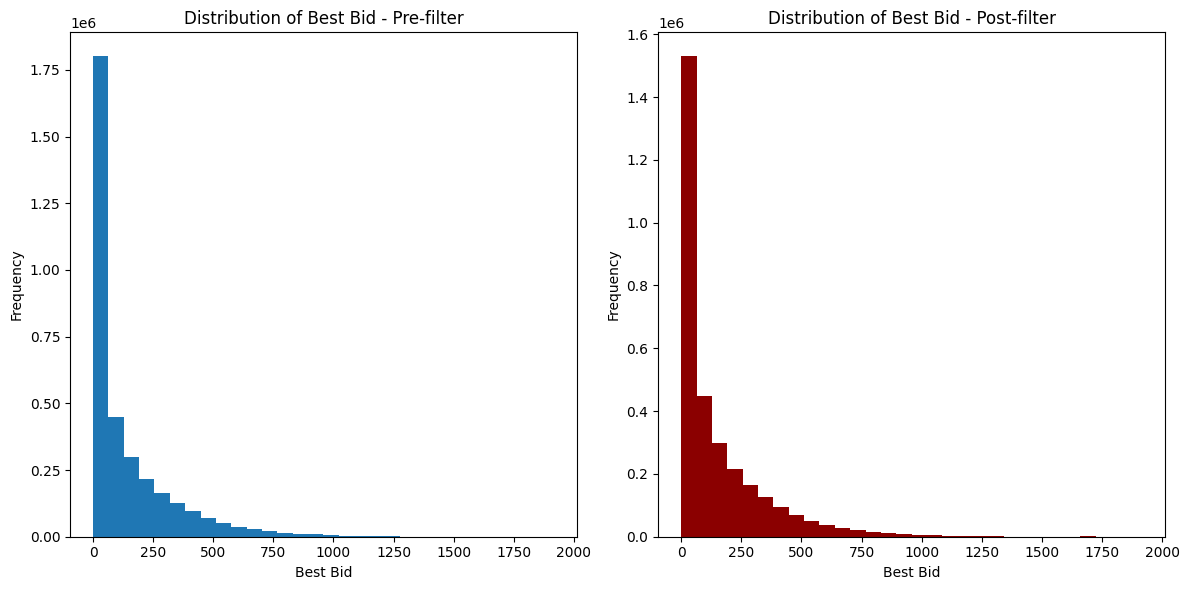

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of best_bid for optm_l1_id
axes[0].hist(optm_l1_id['best_bid'], bins=30)
axes[0].set_xlabel('Best Bid')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Best Bid - Pre-filter')

# Plot distribution of best_bid for optm_l1_zbid
axes[1].hist(optm_l1_zbid['best_bid'], bins=30, color='darkred')
axes[1].set_xlabel('Best Bid')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Best Bid - Post-filter')

plt.tight_layout()
plt.show()


## Filter Options with Vol = 0

In Table B.1 the paper includes a filter to exclude options where the volume is zero. Based on the table, after applying the filter the number of options deleted is zero. From our analysis, there are over 2 million rows with a volume of zero. As a result, we decided to not apply this filter to avoid dramatically skewing our results away from the original table.

In [12]:
optm_l1_zvol = f1.delete_zero_volume_filter(optm_l1_zbid)

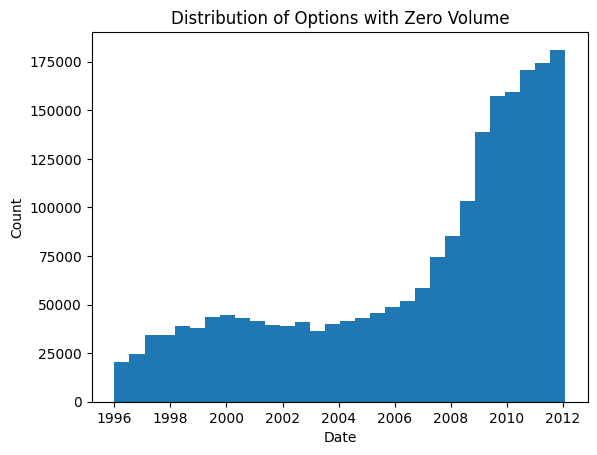

In [13]:
zero_vol_rows = optm_l1_zbid[optm_l1_zbid['volume'] == 0]
plt.hist(zero_vol_rows['date'], bins=30)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Options with Zero Volume')
plt.show()


## Summarize Level 1 Filters

After application of the level 1 filters, quotes with zero bids was the primary driver of deleted observations.

In [14]:
df2, df2_sum, df2_B1 = f1.appendixBfilter_level1(optm_l1_load)
df2_B1 = df2_B1.reset_index().rename(columns={'index': 'Substep'}).set_index(['Step', 'Substep']).map('{:,.0f}'.format)
df2_B1 = df2_B1.map(lambda x: '' if str(x).lower() == 'nan' else x)
df2_B1

Deleted  Remaining
Step            Substep                                     
Starting        Calls0                             1,704,220
                Puts0                              1,706,360
                All0                               3,410,580
Level 1 filters Identical                       0           
                Identical except price         10           
                Bid = 0                   272,078           
                Volume = 0              2,093,744           
                All1                               1,044,748